# Leveraging Agents with LangChain

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio. You can also run on a local setup, as long as you have the right IAM credentials to invoke the Claude model via Bedrock*

### Building  - Key Elements

The first process in a building a contextual-aware chatbot is to identify the tools which can be called by the LLM's. 

Second process is the user request orchestration , interaction,  invoking and returing the results

### Architecture [Weather lookup]
We Search and look for the Latitude and Longitude and then invoke the weather app to get predictions

![Amazon Bedrock - Agents Interface](./images/weather.jpg)

#### Please un comment and install the libraries below if you do not have these 

In [3]:
!pip install langchain==0.1.17
!pip install faiss-cpu==1.8.0
!pip install pypdf
!pip install langchain_aws
!pip install boto3
!pip install langchain-anthropic

# Set up Bedrock client

In [19]:
from langchain_aws import ChatBedrock
from langchain_core.messages import HumanMessage
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.agents import load_tools, initialize_agent, Tool, AgentType
from langchain.llms.bedrock import Bedrock
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain_core.output_parsers import StrOutputParser
from langchain.tools import tool, StructuredTool
from typing import Optional, List, Any
import requests
import json
import re
from PIL import Image
from io import BytesIO, StringIO
from IPython.display import display, Markdown, Pretty
from langchain.callbacks.manager import CallbackManagerForLLMRun
import sys
import textwrap
import boto3
import os
from pprint import pprint

In [11]:
region = os.environ.get("AWS_REGION")
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=region,
)

# Get Bedrock LLM

In [12]:
model_parameter = {"temperature": 0.0, "top_p": .5, "max_tokens_to_sample": 2000}
modelId = "anthropic.claude-v2"
llm = ChatBedrock(
    model_id=modelId,
    client=boto3_bedrock,
    model_kwargs={"temperature": 0.1},
)

# Building an Agent

# 1. Tooling

## 1.1 Weather tool

In [39]:
@tool ("get_lat_long")
def get_lat_long(place: str) -> dict:
    """Returns the latitude and longitude for a given place name as a dict object of python."""
    url = "https://nominatim.openstreetmap.org/search"

    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    params = {'q': place, 'format': 'json', 'limit': 1}
    response = requests.get(url, params=params, headers=headers).json()

    if response:
        lat = response[0]["lat"]
        lon = response[0]["lon"]
        return {"latitude": lat, "longitude": lon}
    else:
        return None

##  Try out the OSM API to retrieve coordinates

In [55]:
# get the latitude and longitude for a certain location
coordinates = get_lat_long("Zurich")
if not coordinates:
    print("Something went wrong")
else:
    print(coordinates)

{'latitude': '47.3744489', 'longitude': '8.5410422'}


# Task 1: The function below is incomplete. pls fix ;)

In [ ]:
# Please fill in the missing pieces of the function definition to create a get_weather function that calls the open-meteo API for getting the current weather based on input coordinates (latitude and longitude)
# use the requests library to call the URI and
# return the response as dictionary

@tool ("get_weather")
def get_weather() -> dict:
  """Returns weather data for a given latitude and longitude."""
  url = f"https://api.open-meteo.com/v1/forecast?latitude={}&longitude={}&current_weather=true"
    
  return

In [56]:
# if your function is ready, you can retrieve the weather for the coordinates from above
response = get_weather(coordinates)
response

{'latitude': 47.38,
 'longitude': 8.539999,
 'generationtime_ms': 0.04100799560546875,
 'utc_offset_seconds': 0,
 'timezone': 'GMT',
 'timezone_abbreviation': 'GMT',
 'elevation': 416.0,
 'current_weather_units': {'time': 'iso8601',
  'interval': 'seconds',
  'temperature': '°C',
  'windspeed': 'km/h',
  'winddirection': '°',
  'is_day': '',
  'weathercode': 'wmo code'},
 'current_weather': {'time': '2024-05-21T19:30',
  'interval': 900,
  'temperature': 14.9,
  'windspeed': 5.8,
  'winddirection': 176,
  'is_day': 0,
  'weathercode': 80}}

## Ask the LLM how the weather is in a specific location

In [42]:
llm.invoke("Can you check the weather in Zurich for me?")

AIMessage(content='Unfortunately I don\'t have direct access to real-time weather data for specific locations. However, I can suggest searching the web or using a weather app to look up the current weather conditions in Zurich. You could search for something like "Zurich weather" to find weather reports and forecasts for that city. Let me know if you need any other help finding weather information!', additional_kwargs={'usage': {'prompt_tokens': 20, 'completion_tokens': 80, 'total_tokens': 100}}, response_metadata={'model_id': 'anthropic.claude-v2', 'usage': {'prompt_tokens': 20, 'completion_tokens': 80, 'total_tokens': 100}}, id='run-0c358ac2-c84a-49a6-b435-a2f21d16c09c-0')

## It is not able ot answer, so let's add a tool to make it capable to do so

## 1.2 Provide weather tool to LLM

In [43]:
tools_list = [get_lat_long, get_weather]
for tools_s in tools_list:
    display(Pretty((f"Tool:name={tools_s.name}::args={tools_s.args}:: discription={tools_s.description}::")))

Tool:name=get_lat_long::args={'place': {'title': 'Place', 'type': 'string'}}:: discription=get_lat_long(place: str) -> dict - Returns the latitude and longitude for a given place name as a dict object of python.::

Tool:name=get_weather::args={'latitude': {'title': 'Latitude', 'type': 'string'}, 'longitude': {'title': 'Longitude', 'type': 'string'}}:: discription=get_weather(latitude: str, longitude: str) -> dict - Returns weather data for a given latitude and longitude.::

In [44]:
llm_agent = initialize_agent(
    tools_list, 
    llm, 
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION, #SELF_ASK_WITH_SEARCH,# CONVERSATIONAL_REACT_DESCRIPTION, # ZERO_SHOT_REACT_DESCRIPTION, 
    verbose=True,
    max_iteration=3,
    return_intermediate_steps=True,
    max_execution_time=60
)
pprint(f"The prompt:template:used:was ---- > \n\n{llm_agent.agent.llm_chain.prompt}\n")

('The prompt:template:used:was ---- > \n'
 '\n'
 "input_variables=['agent_scratchpad', 'input'] "
 'messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], '
 "template='Respond to the human as helpfully and accurately as possible. You "
 'have access to the following tools:\\n\\nget_lat_long: get_lat_long(place: '
 'str) -> dict - Returns the latitude and longitude for a given place name as '
 "a dict object of python., args: {{\\'place\\': {{\\'title\\': \\'Place\\', "
 "\\'type\\': \\'string\\'}}}}\\nget_weather: get_weather(latitude: str, "
 'longitude: str) -> dict - Returns weather data for a given latitude and '
 "longitude., args: {{\\'latitude\\': {{\\'title\\': \\'Latitude\\', "
 "\\'type\\': \\'string\\'}}, \\'longitude\\': {{\\'title\\': \\'Longitude\\', "
 "\\'type\\': \\'string\\'}}}}\\n\\nUse a json blob to specify a tool by "
 'providing an action key (tool name) and an action_input key (tool '
 'input).\\n\\nValid "action" values: "Final Answer"

In [45]:
llm_agent.invoke({"input": "Can you check the weather in Zurich for me?"})



> Entering new AgentExecutor chain...
Let me check on that for you.

Thought: To look up the weather in Zurich, I first need to get the latitude and longitude coordinates for Zurich. I can use the get_lat_long tool for that.

Action:
```json
{
  "action": "get_lat_long",
  "action_input": "Zurich"
}
```


Observation: {'latitude': '47.3744489', 'longitude': '8.5410422'}
Thought:Now that I have the latitude and longitude for Zurich, I can use the get_weather tool to get the current weather data for that location.

Action:
```json  
{
  "action": "get_weather",
  "action_input": {
    "latitude": "47.3744489",
    "longitude": "8.5410422"
  }
}
```


Observation: {'latitude': 47.38, 'longitude': 8.539999, 'generationtime_ms': 0.04303455352783203, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 416.0, 'current_weather_units': {'time': 'iso8601', 'interval': 'seconds', 'temperature': '°C', 'windspeed': 'km/h', 'winddirection': '°', 'is_day': '', '

{'input': 'Can you check the weather in Zurich for me?',
 'output': 'Here is the current weather in Zurich based on the latitude and longitude I looked up:\n\nThe current temperature is 14.9°C. The wind speed is 5.8 km/h from the south (176°). The weather code indicates broken clouds. This data is as of 7:30 PM local Zurich time.  \n\nLet me know if you need any other weather information for Zurich!',
 'intermediate_steps': [(AgentAction(tool='get_lat_long', tool_input='Zurich', log='Let me check on that for you.\n\nThought: To look up the weather in Zurich, I first need to get the latitude and longitude coordinates for Zurich. I can use the get_lat_long tool for that.\n\nAction:\n```json\n{\n  "action": "get_lat_long",\n  "action_input": "Zurich"\n}\n```\n\n'),
   {'latitude': '47.3744489', 'longitude': '8.5410422'}),
  (AgentAction(tool='get_weather', tool_input={'latitude': '47.3744489', 'longitude': '8.5410422'}, log='Now that I have the latitude and longitude for Zurich, I can use

# 2. Create retriever tool for RAG (retrieval augmented generation)

## 2.1 Create Vector DB in memory with Amazon SageMaker FAQ as content
The file can be [found here](./rag_data/Amazon_SageMaker_FAQs.pdf)

In [47]:
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import TextLoader, PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import CharacterTextSplitter
from langchain.embeddings.bedrock import BedrockEmbeddings
from langchain_aws.chat_models.bedrock import ChatBedrock
from langchain.memory import ConversationBufferMemory

loader = PyPDFLoader("./rag_data/Amazon_SageMaker_FAQs.pdf")
bedrock_client = boto3_bedrock
texts = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0).split_documents(loader.load())
embed_model = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=bedrock_client)
#- create the vector store
db = FAISS.from_documents(texts, embed_model)

retriever = db.as_retriever(search_kwargs={"k": 4})
tool_search = create_retriever_tool(
    retriever=retriever,
    name="search_sagemaker_policy",
    description="Searches and returns excerpts for any question about SageMaker",
)
pprint(tool_search.func)
tool_search.args_schema.schema()

functools.partial(<function _get_relevant_documents at 0x7fa8e5cf60e0>, retriever=VectorStoreRetriever(tags=['FAISS', 'BedrockEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7fa8e4857550>, search_kwargs={'k': 4}), document_prompt=PromptTemplate(input_variables=['page_content'], template='{page_content}'), document_separator='\n\n')


{'title': 'RetrieverInput',
 'description': 'Input to the retriever.',
 'type': 'object',
 'properties': {'query': {'title': 'Query',
   'description': 'query to look up in retriever',
   'type': 'string'}},
 'required': ['query']}

# Task 2: Based on the implementation from above, please add the retriever functionality as tool and initialize the agent again 

In [48]:
# write your code here, no imports are needed. Take the retriever tool from above and integrate it into the LLM, to be able to interact with the SageMaker FAQ document





## Let's test the retriever tool

In [49]:
# After finishing, test your new tool by running this cell
llm_agent.invoke({"input": "What is a Amazon SageMaker pipeline?"})

NameError: name 'react_agent' is not defined

In [63]:
# Let's check whether the weather tool is still working
llm_agent.invoke({"input": "How is the weather in Porto"})



> Entering new AgentExecutor chain...
Let me check on that for you.

Thought: To get the weather for Porto, I first need to get the latitude and longitude coordinates using the get_lat_long tool.

Action:
```json
{
  "action": "get_lat_long",
  "action_input": "Porto"
}
```


Observation: {'latitude': '41.1494512', 'longitude': '-8.6107884'}
Thought:Now that I have the latitude and longitude for Porto, I can get the current weather conditions using the get_weather tool.

Action:
```json  
{
  "action": "get_weather",
  "action_input": {
    "latitude": "41.1494512",
    "longitude": "-8.6107884"
  }
}
```


Observation: {'latitude': 41.15, 'longitude': -8.610001, 'generationtime_ms': 0.12099742889404297, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 97.0, 'current_weather_units': {'time': 'iso8601', 'interval': 'seconds', 'temperature': '°C', 'windspeed': 'km/h', 'winddirection': '°', 'is_day': '', 'weathercode': 'wmo code'}, 'current_weathe

{'input': 'How is the weather in Porto',
 'output': 'Here is the current weather for Porto:\n\nThe latitude and longitude coordinates for Porto are 41.1494512, -8.6107884. The current weather shows a temperature of 15.5°C, wind speed of 10.5 km/h from the west, and clear skies. The weather data was generated at 7:30 PM GMT on May 21, 2024. Let me know if you need any other weather details for Porto!',
 'intermediate_steps': [(AgentAction(tool='get_lat_long', tool_input='Porto', log='Let me check on that for you.\n\nThought: To get the weather for Porto, I first need to get the latitude and longitude coordinates using the get_lat_long tool.\n\nAction:\n```json\n{\n  "action": "get_lat_long",\n  "action_input": "Porto"\n}\n```\n\n'),
   {'latitude': '41.1494512', 'longitude': '-8.6107884'}),
  (AgentAction(tool='get_weather', tool_input={'latitude': '41.1494512', 'longitude': '-8.6107884'}, log='Now that I have the latitude and longitude for Porto, I can get the current weather condition

# 3. Build a dog image tool

# Task 3: Build a tool for the LLM that fetches images from different dog breeds.

In [70]:
# Please use the Dog API (https://dog.ceo/dog-api/documentation), and more specifically the random breed endpoint (https://dog.ceo/dog-api/breeds-list)
# Based on a breed input, the LLM should have a tool available to call the API
# at the end of the notebook, you can find code to display the image, the task is done, if you can display a random image based on the LLM output

In [65]:
# function

In [66]:
# agent

In [67]:
chain_output = llm_agent.invoke({"input": "give me a labrador image"})
chain_output



> Entering new AgentExecutor chain...
Here is a JSON blob to get a labrador image using the get_dog_image tool:

Action:
```
{
  "action": "get_dog_image",
  "action_input": "labrador" 
}
```


Observation: {'message': 'https://images.dog.ceo/breeds/labrador/n02099712_8719.jpg', 'status': 'success'}
Thought:Here is a labrador image:

Action:
```
{
  "action": "Final Answer", 
  "action_input": "Here is a labrador image: https://images.dog.ceo/breeds/labrador/n02099712_8719.jpg"
}
```

> Finished chain.


{'input': 'give me a labrador image',
 'output': 'Here is a labrador image: https://images.dog.ceo/breeds/labrador/n02099712_8719.jpg',
 'intermediate_steps': [(AgentAction(tool='get_dog_image', tool_input='labrador', log='Here is a JSON blob to get a labrador image using the get_dog_image tool:\n\nAction:\n```\n{\n  "action": "get_dog_image",\n  "action_input": "labrador" \n}\n```\n\n'),
   {'message': 'https://images.dog.ceo/breeds/labrador/n02099712_8719.jpg',
    'status': 'success'})]}

## Display the dog image

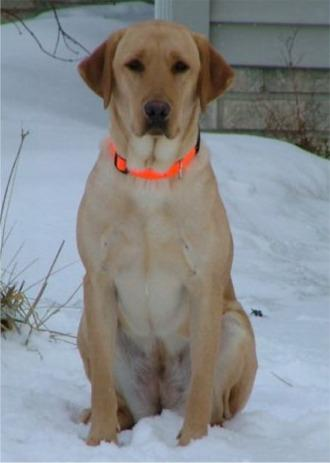

In [69]:
if chain_output:
    output_str = chain_output["output"]
    url_pattern = r'(https?://[^\s]+)'
    url = re.findall(url_pattern, output_str)[0]
    print(url)
else:
    raise TypeError("Output cannot be of NoneType")

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image from the response content
    img = Image.open(BytesIO(response.content))
    
    # Display the image in the notebook
    display(img)
else:
    print("Failed to retrieve the image")
